In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

In [2]:
# Suponiendo que 'df' es tu DataFrame
df = pd.read_csv('df_completo.csv', index_col='Fecha_venta', parse_dates=True)

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 113254 entries, 2021-05-08 to 2024-04-30
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ID_producto    113254 non-null  int64  
 1   Cant_vendidas  113254 non-null  int64  
 2   Precio_unidad  113254 non-null  float64
 3   Dia_sem        113254 non-null  object 
 4   Promocion      113254 non-null  object 
 5   Año            113254 non-null  int64  
 6   Mes            113254 non-null  int64  
 7   Dia_del_Mes    113254 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 7.8+ MB


In [9]:
# Codificación de variables categóricas con OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)  # Esto asegura que la salida sea en formato denso
encoded_features = encoder.fit_transform(df[['Dia_sem', 'Promocion']])
encoded_features_df = pd.DataFrame(encoded_features, index=df.index, columns=encoder.get_feature_names_out())


In [10]:
# Normalización de 'Precio_unidad'
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(df[['Precio_unidad']])
scaled_prices_df = pd.DataFrame(scaled_prices, index=df.index, columns=['Precio_unidad'])

In [11]:
# Combinar todas las características
X = pd.concat([encoded_features_df, scaled_prices_df, df[['Año', 'Mes', 'Dia_del_Mes']]], axis=1)
y = df['Cant_vendidas']

In [12]:
# División en conjuntos de entrenamiento, validación y prueba
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [27]:
import numpy as np
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l1_l2

def build_model():
    model = Sequential([
        Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01), input_shape=(X_train.shape[1],)),
        Dropout(0.5),
        Dense(32, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
        Dropout(0.5),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Preparar los datos (X, y ya deben estar definidos y preprocesados)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
losses = []

for train_index, test_index in kf.split(X):
    # Dividir los datos usando .iloc para acceder por índices numéricos
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Construir el modelo
    model = build_model()
    
    # Entrenar el modelo
    print(f'Training model for fold {fold_no}')
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
    
    # Evaluar el modelo
    scores = model.evaluate(X_test, y_test, verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores}')
    losses.append(scores)
    fold_no += 1

# Calcular promedio de la pérdida
average_loss = np.mean(losses)
print(f'Average Loss: {average_loss}')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training model for fold 1
Score for fold 1: loss of 149.1055908203125
Training model for fold 2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Score for fold 2: loss of 138.3135528564453
Training model for fold 3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Score for fold 3: loss of 128.7842254638672
Training model for fold 4


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Score for fold 4: loss of 133.53834533691406
Training model for fold 5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Score for fold 5: loss of 136.3859100341797
Average Loss: 137.22552490234375


In [28]:
# Compilar el modelo
model.compile(optimizer='adam', loss='mse')

In [32]:
# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))

Epoch 1/50
2832/2832 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 117.8100 - val_loss: 134.0728
Epoch 2/50
2832/2832 ━━━━━━━━━━━━━━━━━━━━ 3s 987us/step - loss: 149.0045 - val_loss: 134.0711
Epoch 3/50
2832/2832 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 125.1790 - val_loss: 134.0731
Epoch 4/50
2832/2832 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 128.7003 - val_loss: 134.0731
Epoch 5/50
2832/2832 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 150.2926 - val_loss: 134.0711
Epoch 6/50
2832/2832 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 150.9754 - val_loss: 134.0722
Epoch 7/50
2832/2832 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 136.0549 - val_loss: 134.0727
Epoch 8/50
2832/2832 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 150.9092 - val_loss: 134.0714
Epoch 9/50
2832/2832 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 138.1068 - val_loss: 134.0721
Epoch 10/50
2832/2832 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 134.5048 - val_loss: 134.0723
Epoch 11/50
2832/2832 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 137.2714 - val

In [33]:
# Evaluar el modelo con el conjunto de prueba
test_loss = model.evaluate(X_test, y_test)

708/708 ━━━━━━━━━━━━━━━━━━━━ 1s 748us/step - loss: 179.8071


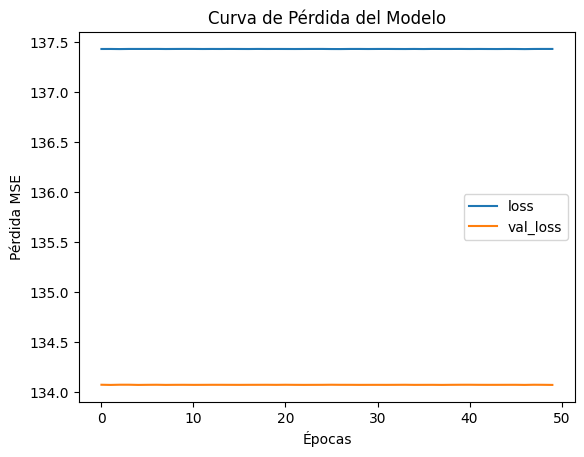

In [34]:
# Opcional: Visualizar la curva de pérdida
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Curva de Pérdida del Modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida MSE')
plt.legend()
plt.show()

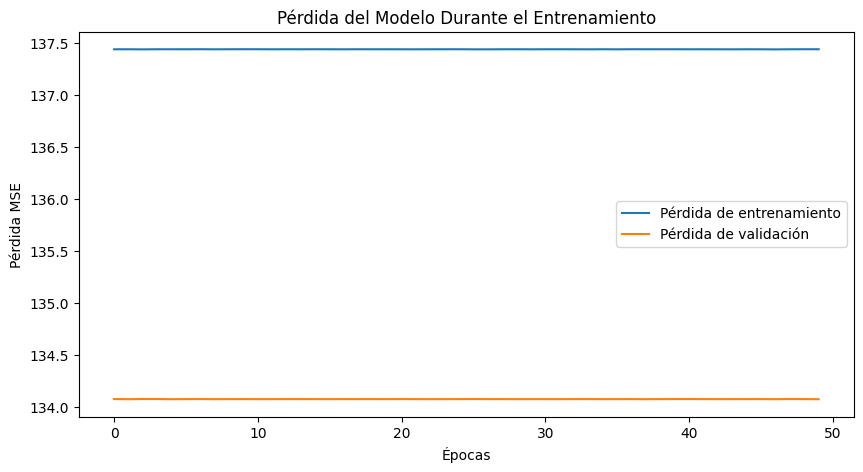

In [35]:
import matplotlib.pyplot as plt

# Suponiendo que 'history' es el resultado devuelto por model.fit()
plt.figure(figsize=(10, 5))

# Graficar la pérdida de entrenamiento
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')

# Graficar la pérdida de validación
plt.plot(history.history['val_loss'], label='Pérdida de validación')

plt.title('Pérdida del Modelo Durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida MSE')
plt.legend()

plt.show()
